In [1]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [2]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding "  # this disables constant folding
#     # "--xla_cpu_use_thunk_runtime=false "
# )
from desc import set_device
set_device("gpu")

In [3]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_explain_cache_misses", True)

In [4]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [5]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [6]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.15.0+45.g71d59bb76.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 10.80 GB available memory.


In [7]:
eq = get("precise_QA")

In [8]:
eq.L_basis.modes

array([[ 0,  0, -8],
       [ 1,  1, -8],
       [ 2,  0, -8],
       [ 2,  2, -8],
       [ 3,  1, -8],
       [ 3,  3, -8],
       [ 4,  0, -8],
       [ 4,  2, -8],
       [ 4,  4, -8],
       [ 5,  1, -8],
       [ 5,  3, -8],
       [ 5,  5, -8],
       [ 6,  0, -8],
       [ 6,  2, -8],
       [ 6,  4, -8],
       [ 6,  6, -8],
       [ 7,  1, -8],
       [ 7,  3, -8],
       [ 7,  5, -8],
       [ 7,  7, -8],
       [ 8,  0, -8],
       [ 8,  2, -8],
       [ 8,  4, -8],
       [ 8,  6, -8],
       [ 8,  8, -8],
       [ 0,  0, -7],
       [ 1,  1, -7],
       [ 2,  0, -7],
       [ 2,  2, -7],
       [ 3,  1, -7],
       [ 3,  3, -7],
       [ 4,  0, -7],
       [ 4,  2, -7],
       [ 4,  4, -7],
       [ 5,  1, -7],
       [ 5,  3, -7],
       [ 5,  5, -7],
       [ 6,  0, -7],
       [ 6,  2, -7],
       [ 6,  4, -7],
       [ 6,  6, -7],
       [ 7,  1, -7],
       [ 7,  3, -7],
       [ 7,  5, -7],
       [ 7,  7, -7],
       [ 8,  0, -7],
       [ 8,  2, -7],
       [ 8,  

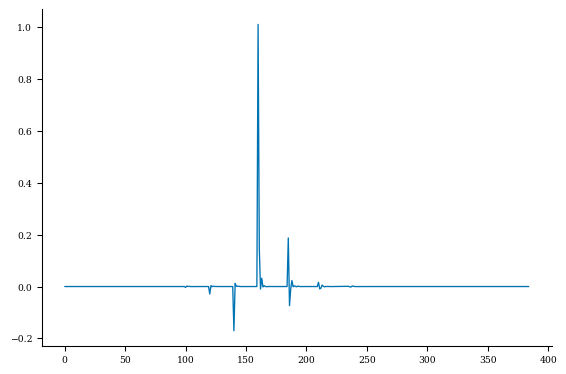

In [9]:
plt.plot(eq.R_lmn)

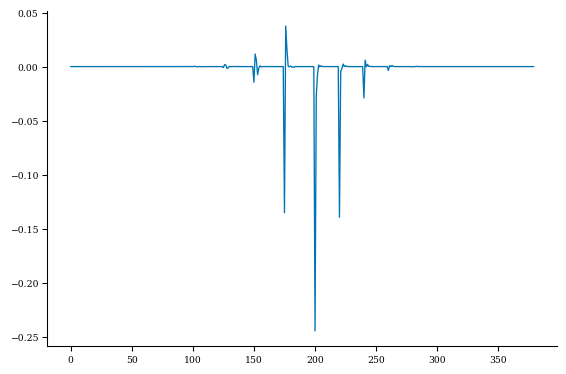

In [10]:
plt.plot(eq.Z_lmn)

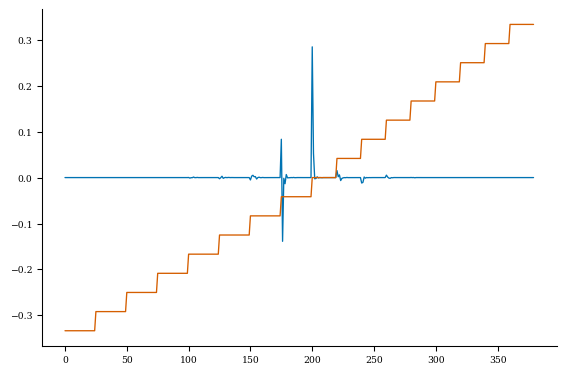

In [11]:
plt.plot(eq.L_lmn)
plt.plot(eq.L_basis.modes[:, 2]/24)

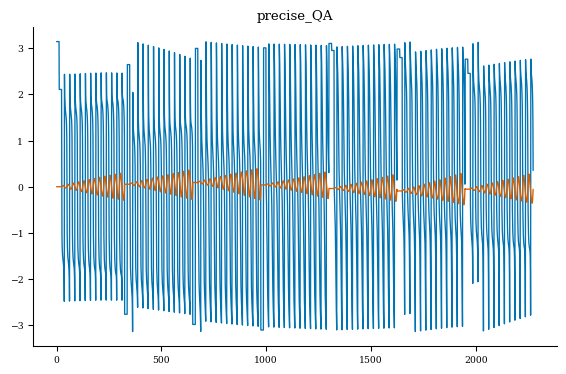

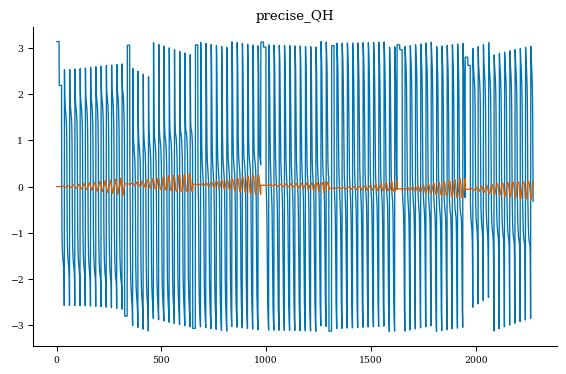

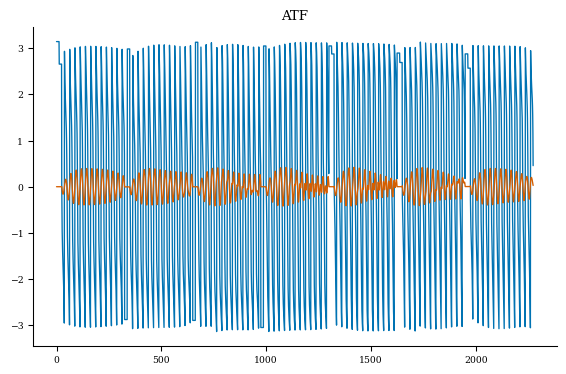

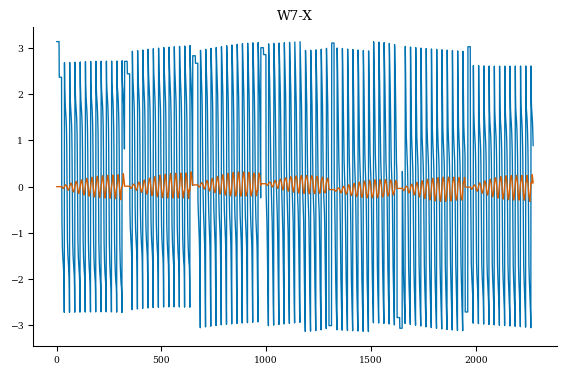

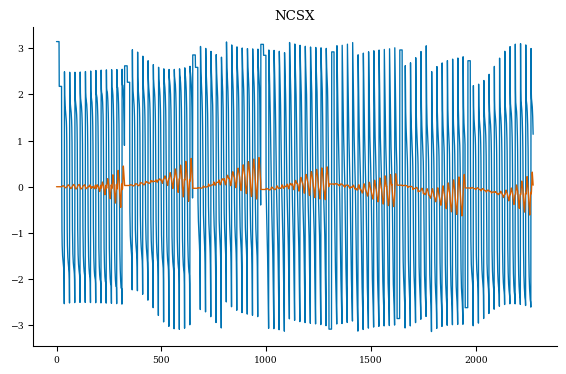

In [105]:
names = [
    "precise_QA", "precise_QH", "ATF", "W7-X", "NCSX"
]
for name in names:
    eq = get(name)    
    axis_grid = LinearGrid(rho=[0.001]*13, M=12, N=3, NFP=eq.NFP)
    grid = LinearGrid(L=12, M=12, N=3, NFP=eq.NFP)
    data = eq.compute(["lambda", "R", "Z"], grid=grid)
    axis_data = eq.compute(["R", "Z"], grid=axis_grid)
    theta = jnp.atan2((data["Z"] - axis_data["Z"]), (data["R"] - axis_data["R"]))
    plt.figure()
    plt.plot(theta, label="theta")
    plt.plot(data["lambda"], label="lambda")
    plt.title(name)

In [74]:
# create initial surface. Aspect ratio ~ 8, circular cross section with slight
# axis torsion to make it nonplanar
surf = FourierRZToroidalSurface(
    R_lmn=[1, 0.125, 0.1],
    Z_lmn=[-0.125, -0.1],
    modes_R=[[0, 0], [1, 0], [0, 1]],
    modes_Z=[[-1, 0], [0, -1]],
    NFP=4,
)
# create initial equilibrium. Psi chosen to give B ~ 1 T. Could also give profiles here,
# default is zero pressure and zero current
eq = Equilibrium(M=10, N=10, Psi=0.04, surface=surf)

In [88]:
from desc.objectives.objective_funs import _Objective
class LambdaPenalty(_Objective):
    _scalar = True
    _fixed = False
    _units = "(Unknown)"
    _print_value_fmt = "Custom linear objective value: "

    def __init__(
        self,
        thing,
        target=None,
        bounds=None,
        weight=1,
        normalize=False,
        normalize_target=False,
        name="custom linear",
        jac_chunk_size=None,
    ):
        if target is None and bounds is None:
            target = 0
        super().__init__(
            things=thing,
            target=target,
            bounds=bounds,
            weight=weight,
            normalize=normalize,
            normalize_target=normalize_target,
            name=name,
            jac_chunk_size=jac_chunk_size,
        )

    def build(self, use_jit=False, verbose=1):
        self._dim_f = 1
        super().build(use_jit=use_jit, verbose=verbose)

    def compute(self, params, constants=None):
        return jnp.sum(params["L_lmn"]**2)

In [89]:
# obj = ObjectiveFunction(ForceBalance(eq))
obj = ObjectiveFunction([ForceBalance(eq), LambdaPenalty(eq, weight=1e6)])
cons = get_fixed_boundary_constraints(eq)
cons = maybe_add_self_consistency(eq, cons)
cons = ObjectiveFunction(cons)
objective = LinearConstraintProjection(obj, cons)
objective.build()

Building objective: force
Precomputing transforms
Building objective: custom linear
Building objective: lcfs R
Building objective: lcfs Z
Building objective: fixed Psi
Building objective: fixed pressure
Building objective: fixed current
Building objective: fixed sheet current
Building objective: self_consistency R
Building objective: self_consistency Z
Building objective: lambda gauge
Building objective: axis R self consistency
Building objective: axis Z self consistency


In [90]:
x = objective.x()
J = objective.jac_scaled_error(x).block_until_ready()

In [91]:
cond = jnp.linalg.cond(J)
print(f"{cond:.2e}")

8.24e+08


In [92]:
u, s, v = jnp.linalg.svd(J, full_matrices=False)

In [93]:
f"{s.min():.2e}"

'3.00e-06'

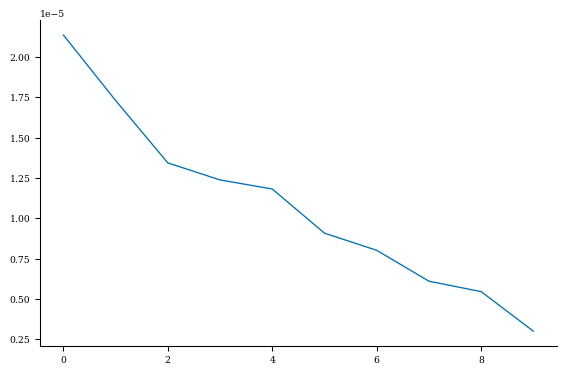

In [94]:
plt.plot(s[-10:])

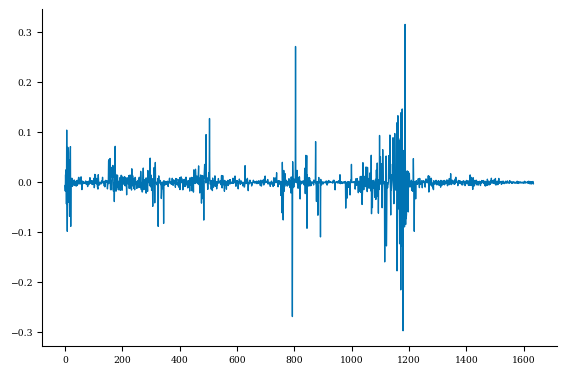

In [95]:
plt.plot(v[:, -1])

In [96]:
for key, val in eq.x_idx.items():
    if val.size > 1:
        print(f"{key}: {val[0]}-{val[-1]}")

R_lmn: 0-695
Z_lmn: 696-1385
L_lmn: 1386-2075
p_l: 2076-2081
c_l: 2082-2087
Ra_n: 2089-2099
Za_n: 2100-2109
Rb_lmn: 2110-2330
Zb_lmn: 2331-2550


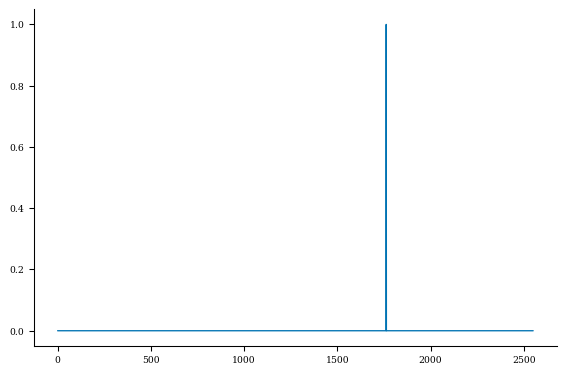

In [99]:
plt.plot(objective._feasible_tangents[:, 1300])

In [98]:
objective._feasible_tangents.shape

(2551, 1635)